[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nils-holmberg/cca-ccg/blob/main/jnb/cv-colab.ipynb)

In [1]:
!git clone https://github.com/nils-holmberg/cca-ccg.git


Cloning into 'cca-ccg'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 76 (delta 41), reused 68 (delta 33), pack-reused 0
Receiving objects: 100% (76/76), 413.32 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
!pip install -q opencv-python

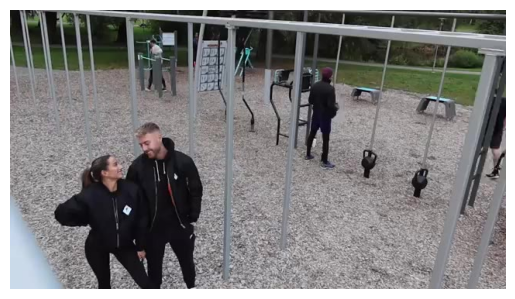

In [3]:
import cv2
import matplotlib.pyplot as plt

# Read the image using OpenCV
image_path = 'cca-ccg/fig/04Ge3YMUnWc.mp4-00049.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [4]:
!pip install -q transformers timm torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.6 MB/s eta 0:00:00


In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch


In [6]:
from PIL import Image
import requests

In [7]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = "https://raw.githubusercontent.com/nils-holmberg/scom-dm/main/img/04Ge3YMUnWc.mp4-00049.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected person with confidence 0.991 at location [613.08, 114.2, 639.98, 217.48]
Detected person with confidence 0.997 at location [175.79, 35.3, 198.81, 103.14]
Detected person with confidence 0.999 at location [148.13, 145.74, 249.37, 358.95]
Detected person with confidence 0.999 at location [51.63, 186.81, 187.98, 359.18]
Detected person with confidence 0.97 at location [234.81, 29.22, 244.9, 74.18]
Detected person with confidence 1.0 at location [379.96, 72.64, 425.84, 203.58]


In [8]:
import pandas as pd


In [9]:
data = []
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    data.append([model.config.id2label[label.item()], box, round(score.item(), 3)])

# Creating a pandas dataframe
df = pd.DataFrame(data, columns=['Label', 'Pixel Location (x1, y1, x2, y2)', 'Confidence'])
df


,Label,"Pixel Location (x1, y1, x2, y2)",Confidence
0,person,"[613.08, 114.2, 639.98, 217.48]",0.991
1,person,"[175.79, 35.3, 198.81, 103.14]",0.997
2,person,"[148.13, 145.74, 249.37, 358.95]",0.999
3,person,"[51.63, 186.81, 187.98, 359.18]",0.999
4,person,"[234.81, 29.22, 244.9, 74.18]",0.970
5,person,"[379.96, 72.64, 425.84, 203.58]",1.000


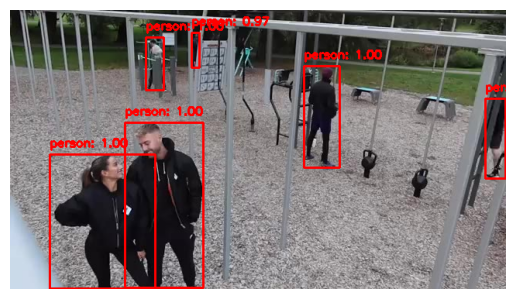

In [10]:
# Draw rectangles, labels, and confidence on the image using OpenCV
for _, row in df.iterrows():
    label, box, confidence = row['Label'], row['Pixel Location (x1, y1, x2, y2)'], row['Confidence']
    x1, y1, x2, y2 = box
    cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    cv2.putText(image_rgb, f'{label}: {confidence:.2f}',
                (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image with bounding boxes, labels, and confidence
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [11]:
# Save the annotated image to the Noteable project
output_image_path = 'Annotated_Image.jpg'
cv2.imwrite(output_image_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
output_image_path


'Annotated_Image.jpg'